In [1]:
from coin2dic import coin2dic
import pandas as pd
import csv
import matplotlib.pyplot as plt
import os
import scipy.signal as signal
import numpy as np
import similaritymeasures
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats

In [2]:
LAST_YEARS_DIR = './Crypto_19-20' 
coins = pd.DataFrame()
for csv_file in os.listdir(LAST_YEARS_DIR):
    file_name = os.path.join(LAST_YEARS_DIR, csv_file)
    coin_dict = coin2dic(file_name)
    coins = coins.append(coin_dict, ignore_index=True)
coins = coins.set_index('Name')
coins.head()

,market_cap,normalized_price,price,volume,year
Name,,,,,
Kyber Network,"[23177641.0, 17634388.0, 21347773.0, 20632706....","[0.09191276595744681, 0.06993085106382979, 0.0...","[0.172796, 0.13147, 0.136816, 0.132233, 0.1169...","[3041633.0, 2404111.0, 3733933.0, 2385264.0, 1...","[2019.0, 2019.0, 2019.0, 2019.0, 2019.0, 2019...."
XRP,"[15028369642.0, 13045216854.0, 13181215054.0, ...","[0.5943283143852313, 0.5128054968048773, 0.518...","[0.368395, 0.317863, 0.321177, 0.309439, 0.302...","[492558794.0, 452358902.0, 407205881.0, 362599...","[2019.0, 2019.0, 2019.0, 2019.0, 2019.0, 2019...."
Stellar,"[2306881891.0, 1981659222.0, 2002863078.0, 184...","[0.6198204135431254, 0.5334510668094571, 0.539...","[0.120384, 0.103609, 0.104702, 0.096316, 0.081...","[93094440.0, 119389904.0, 123424390.0, 1349884...","[2019.0, 2019.0, 2019.0, 2019.0, 2019.0, 2019...."
Tether,"[1910347641.0, 1967105373.0, 2050721693.0, 203...","[1.0, 1.0, 1.0, 0.9901960784313726, 0.98039215...","[1.02, 1.02, 1.02, 1.01, 1.0, 1.0, 1.0, 1.01, ...","[4224650070.0, 3380321686.0, 4389435191.0, 393...","[2019.0, 2019.0, 2019.0, 2019.0, 2019.0, 2019...."
aelf,"[35560648.0, 27831782.0, 30215498.0, 29471180....","[0.5246585641932365, 0.4106276800542001, 0.445...","[0.127002, 0.099399, 0.107912, 0.105254, 0.098...","[4491096.0, 2613764.0, 3744827.0, 2588166.0, 1...","[2019.0, 2019.0, 2019.0, 2019.0, 2019.0, 2019...."


## Clustering

In [3]:
import tslearn.clustering as tsclustering
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

### Preprocesamiento de las series temporales

In [4]:
normalized_prices = np.array([np.array(value) for value in coins['normalized_price'].values])
np.random.shuffle(normalized_prices)
normalized_prices.reshape(-1,1)
normalized_prices = TimeSeriesScalerMeanVariance().fit_transform(normalized_prices)
normalized_prices = TimeSeriesResampler(sz=64).fit_transform(normalized_prices)

### Como no se sabe la cantidad de clusters que se deben utilizar se buscará este valor a partir de la curva de variación inercia VS K

In [29]:
inertia = []
for n in range(1, 11):
    n_clusters = n
    crypto_cluster = tsclustering.TimeSeriesKMeans(n_clusters = n_clusters,
                                            verbose = False,
                                            n_init = 10,
                                            n_jobs= -1,
                                            tol = 0.0005,
                                            metric = 'dtw')
    y = crypto_cluster.fit_predict(normalized_prices)
    var = crypto_cluster.inertia_
    inertia.append(var)

In [30]:

inertia = inertia[1:]
plt.figure(1, figsize=(20,6));
plt.plot(np.arange(2,10,1),inertia);
plt.plot([5 for n in range(80)],np.arange(4,12,0.1),'--',color='black')
plt.title('Inertia Vs. K', fontsize=20);
plt.ylabel('Inertia', fontsize=20);
plt.yticks(fontsize=15);
plt.xticks(np.arange(2, 11, 1), fontsize=15);
plt.xlabel('K', fontsize=20);
plt.grid(True)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (8,) and (9,)

### El valor elegido para k es 5

In [21]:
del crypto_cluster
n_clusters = 5
crypto_cluster = tsclustering.TimeSeriesKMeans(n_clusters = n_clusters,
                                        verbose = False,
                                        n_init = 100,
                                        n_jobs=-1,
                                        tol = 0.0005,
                                        metric = 'dtw')

crypto_cluster.fit(normalized_prices)
crypto_cluster.to_json('./trained_model_price.json')
y = crypto_cluster.predict(normalized_prices)
distances_price = crypto_cluster.transform(normalized_prices)
print('La inercia es: ',crypto_cluster.inertia_)




La inercia es:  6.939095841999394


### Para comprobar que todos los clusters tengan más o menos la misma distancia se obtiene el promedio de cada cluster

In [22]:
cluster_distance_price = np.zeros(n_clusters)

for n in range(n_clusters):
    cluster_distance_price[n] = round(np.mean([value[n] for value in distances_price]), 2)
print(cluster_distance_price)



[5.32 4.95 5.45 4.68 7.18]


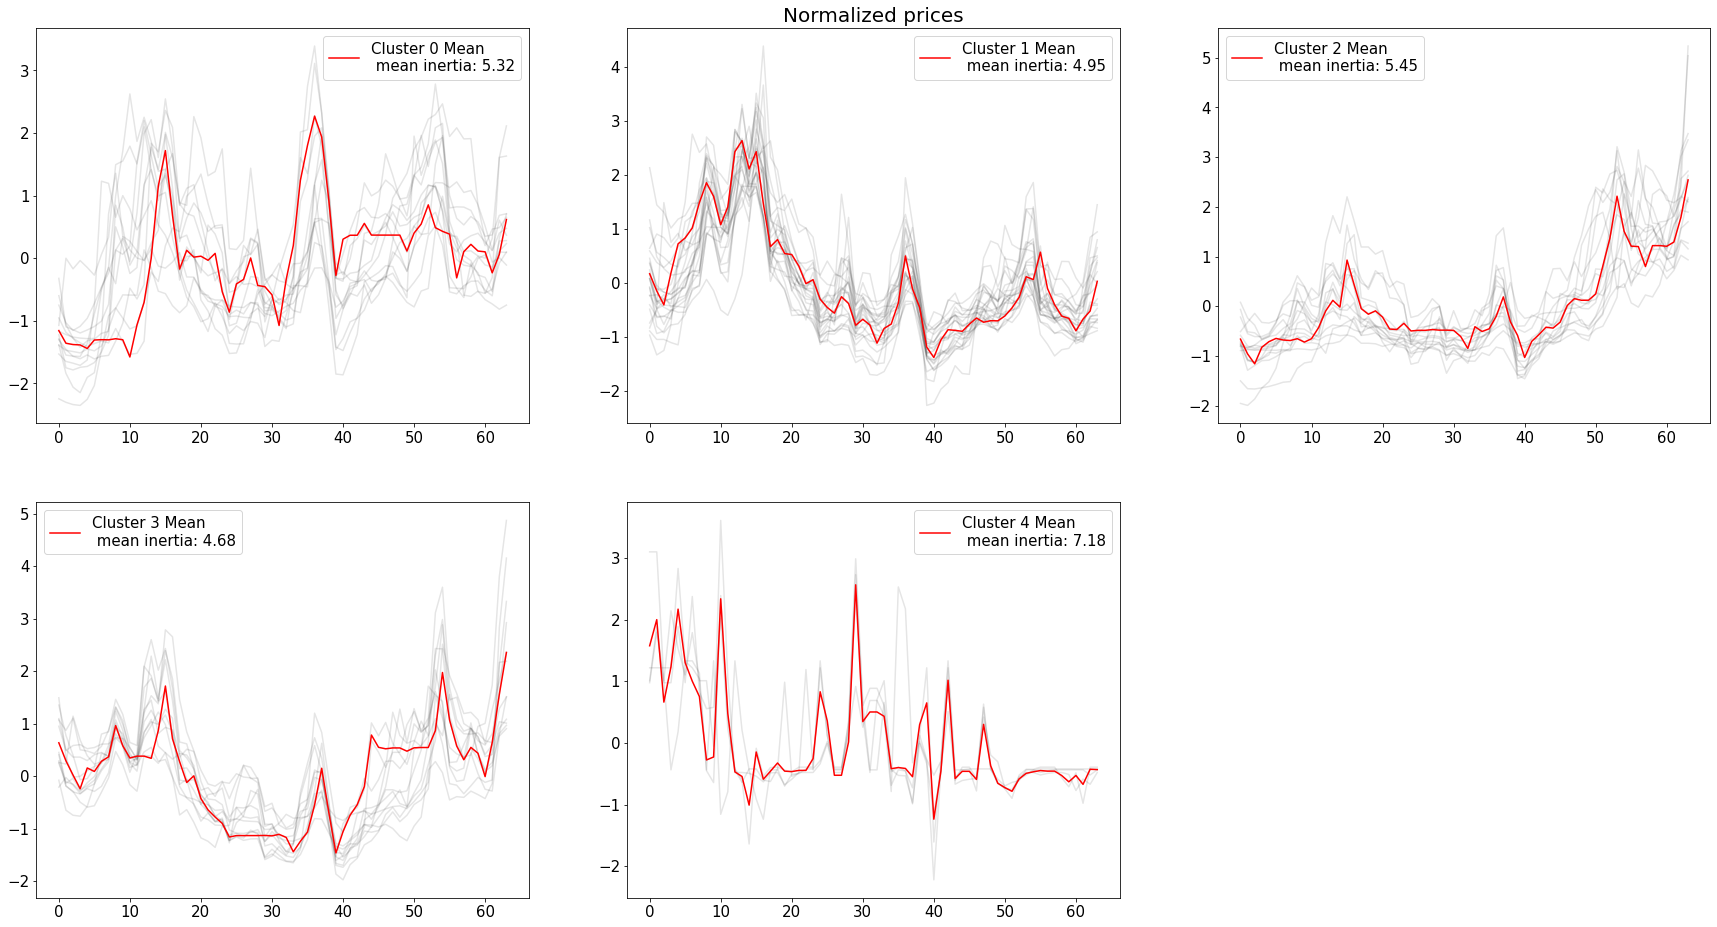

In [23]:
X_train = normalized_prices
y_pred = y
plt.figure(1,figsize=(30,16))
for yi in range(n_clusters): 
    plt.subplot(2, 3, 1 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.1)
    plt.plot(crypto_cluster.cluster_centers_[yi].ravel(),
            "r-",
            label=f'Cluster {yi} Mean\n mean inertia: {cluster_distance_price[yi]}')
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.legend(fontsize=15)
    if yi == 1:
        plt.title("Normalized prices", fontsize=20)



### Se puede ver que los agrupamientos funcionaron correctamente y todos los clusters tienen el mismo orden de magnitud en su dtw promedio por lo que se se estima que el k utilizado es válido.

In [24]:

prices = np.array([np.array(value) for value in coins['normalized_price'].values])
prices.reshape(-1, 1)
prices = TimeSeriesScalerMeanVariance().fit_transform(prices)
prices = TimeSeriesResampler(sz=64).fit_transform(prices)
y = crypto_cluster.predict(prices)
coins['cluster'] = y
cluster_bitcoin = coins.loc['Bitcoin']['cluster']
print(cluster_bitcoin)

2


### El grupo al cual pertenece el bitcoin es el número 2

In [218]:
coins.groupby('cluster').mean()

,correlation,curve_lenght,fretchet,partial_curve_mapping,area_between_curves,dynamic_time_warping
cluster,,,,,,
0,22.195231,3.827000,0.473000,9.523000,17.317000,17.567000
1,25.726757,3.615000,0.573571,14.019286,17.138571,17.387857
2,18.909787,4.970000,0.414000,9.060000,16.798000,16.958667
3,21.755344,4.827727,0.659545,20.135000,19.470000,19.875000
4,39.944271,4.300000,0.792000,39.564000,47.010000,47.456000


### como se ve en la tabla agrupada, el promedio de la distancia de fretchet en el grupo 1 (o sea, el grupo al cual pertenece BTC) es el menor de todos, como es de esperarse. Hay 23 cryptomonedas en esta lista que parecen tener un comportamiento semanal similar al bitcoin.

In [219]:
coins.groupby('cluster').count()

,market_cap,normalized_price,price,volume,year,price_cycle,price_trend,normalized_price_cycle,normalized_price_trend,correlation,curve_lenght,fretchet,partial_curve_mapping,area_between_curves,dynamic_time_warping
cluster,,,,,,,,,,,,,,,
0,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
1,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
2,16,16,16,16,16,16,16,16,16,15,15,15,15,15,15
3,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22
4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


### Se realizará un análisis ANOVA con el fin de determinar si las diferencias entre las distancias  de fretchet promedio de cada cluster son significativas. En caso de que las diferencias sean significativas se puede asumir que la agrupación es correcta, en caso de que no haya diferencias significativas significaría que puede haber curvas agrupadas de forma erronea por lo que se debe corregir el modelo.

Cluster 0: 0.311
Cluster 1: 0.053
Cluster 2: 0.099
Cluster 3: 0.176
Cluster 4: 0.039
Bartlett:  0.146


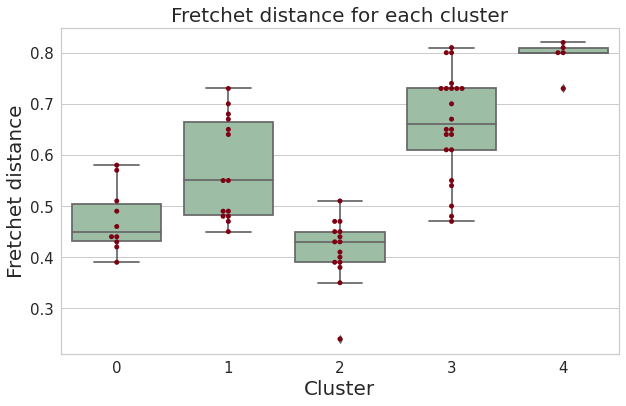

In [230]:

discarted = []
dtw = []
# Test de normalidad Shapiro-Wilks. Si p_value es muy pequeño (< 0,05 ) se rechaza la normalidad
for n in range(n_clusters):
    x = coins[coins.cluster==n]['fretchet'].sort_values()
    if n == cluster_bitcoin:
        x = x[:-1]
    if len(x)>2:
        statistic, p_value = stats.shapiro(x)
        if p_value > 0.05 and len(list(x)) > 3:
            dtw.append(x)
        print(f'Cluster {n}:', round(p_value,3))
# Test de homogeneidad de las varianzas Bartlett>>> Si p_valor es muy pequeño (< 0,05 ) se considera que las varianzas no son homogéneas
dtw = tuple((value.values for value in dtw))
statistic, p_value = stats.bartlett(*dtw)
print('Bartlett: ', round(p_value,3))

plt.figure(1, figsize=(10,6))
plt.figure(1,figsize=(10,6))
ax = sns.boxplot(x='cluster', y='fretchet', data=coins, color='#99c2a2')
ax = sns.swarmplot(x="cluster", y="fretchet", data=coins,color='#7d0013')
plt.title('Fretchet distance for each cluster',fontsize=20)
plt.ylabel('Fretchet distance',fontsize=20)
plt.xlabel('Cluster', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);


### La normalidad en el caso del cluster 4 se rechaza. Sin embargo este cluster es el más alejado del 1, que es grupo de Bitcoin, por lo tanto, se considerará que las diferencias en este caso son significativas. En cuanto a la homogeneidad de varianzas no se rechazó la hipótesis. Por lo tanto se procederá a realizar un análisis ANOVA sin considerar el cluster 4.

In [231]:
f_value, p_value = stats.f_oneway(*dtw)

print(f_value, p_value)

26.072541681896308 9.548076817394015e-11


### El p-valor es menor a 0,05 por lo que existen diferencias significativas entre las medias de las distancias de fretchet de los grupos. Esto sugiere que los agrupamientos son correctos.

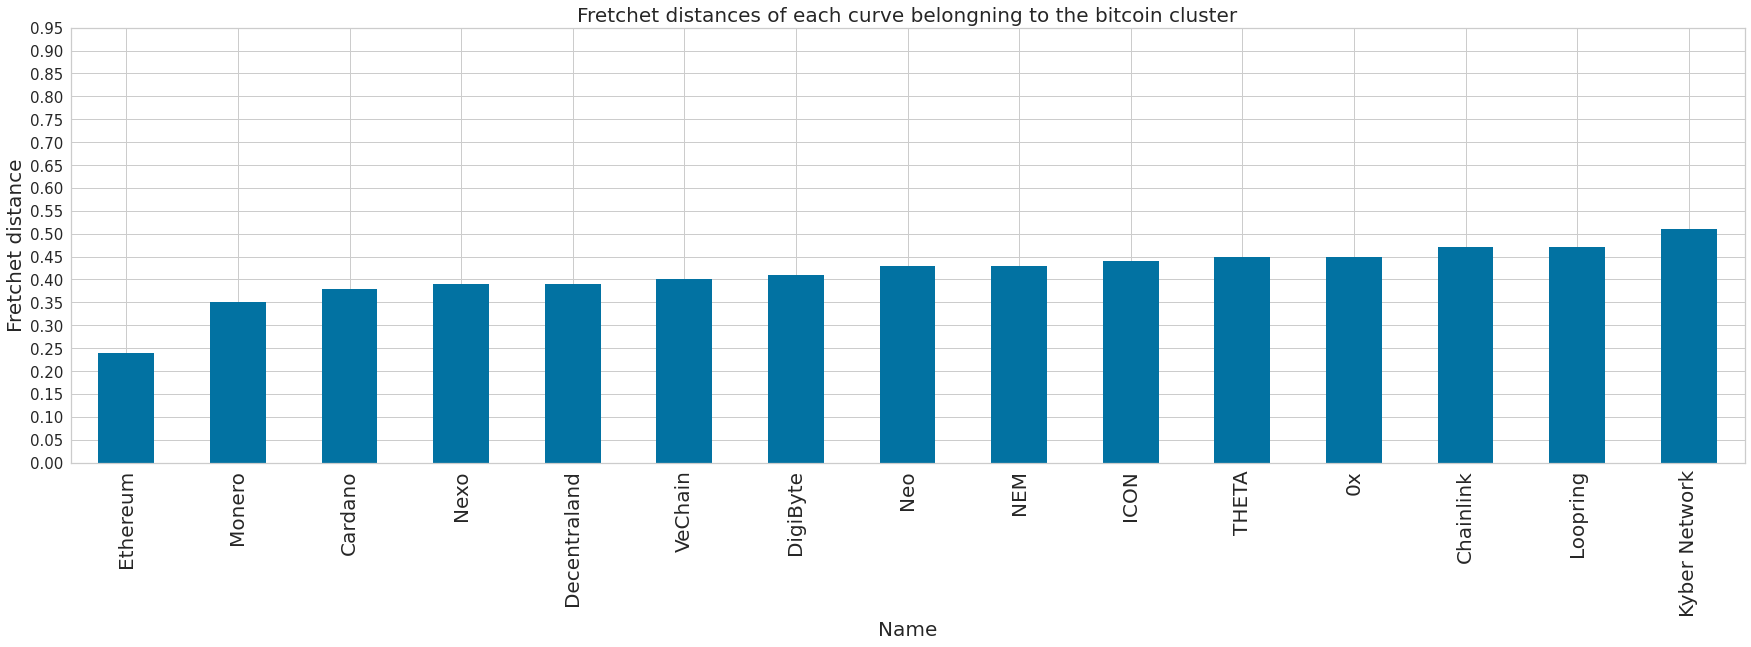

In [234]:
plt.figure(1, figsize=(30,8))
coins[coins.cluster == cluster_bitcoin]['fretchet'].sort_values()[:-1].plot.bar()
plt.title('Fretchet distances of each curve belongning to the bitcoin cluster', fontsize=20)
plt.ylabel('Fretchet distance', fontsize=20)
plt.xlabel('Name',fontsize =20)

plt.yticks(np.arange(0,1,0.05),fontsize=15)
plt.xticks(fontsize=20)
plt.grid(True)


### Conclusión:  Se concluye que el agrupamiento realizado es correcto considerando que las diferencias entre las medias de la distancia de Fretchet es significativa. En el futuro se probará la hipótesis de que es posible aumentar el dataset de entrenamiento de una red neuronal agregando datos de las monedas que se comportan de forma similar. Además se debe comprobar si este agrupamiento se mantiene si en lugar de datos semanales se utilizan datos de cada hora, minuto o día.

###Bibliografía:
https://pypi.org/project/similaritymeasures/
https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.TimeSeriesKMeans.html#tslearn.clustering.TimeSeriesKMeans



In [241]:
crypto_cluster.to_json('trained_model.json')